<a href="https://colab.research.google.com/github/bambithenambi/MechOptimization/blob/main/GPU_Velocity_and_Angle_vs_Height.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# USE GPU-Based

# Formalities #



## Imports

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from timeit import default_timer as timer
from numba import jit, njit, vectorize

## Custom Plot Colormap ##

In [2]:
plt.style.use('seaborn-white')
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Trig Functions in Degrees



``` 
math.sin(angle*math.pi/180)
math.cos(angle*math.pi/180)
math.tan(angle*math.pi/180)
```



# Velocity and Angle Effect on Height of Ball at Target Distance

##Constants##


In [3]:
Ub = 5 # Upper Bound of Target
Lb = 4 # Lower Bound of Target
Ht = 4.5 # Midpoint of Target
Hs = 0.5 # Height of Shooter
Dt = 3 # Distance to Target
Db = 0.18 # Diameter of Ball
halfGrav = -9.81/2

In [12]:
angle=np.arange(1, 90, 0.1)
velocity=np.arange(0.01, 25.01, 0.01)
X, Y = np.meshgrid(angle, velocity)

## Function ##

In [8]:
@vectorize(['float64(float64, float64)',
            'float64(float64, float64)'],
           target='cuda')
def findHeightAtTarget(angle, velocity):
  t = Dt/(velocity*math.cos(angle*math.pi/180))
  return (halfGrav*(t**2))+(velocity*math.sin(angle*math.pi/180)*t)+(Hs)

In [9]:
@vectorize #so simple its actually better to use cpu for 2 million
def vecCondition(item):
  u = -Db/2
  b = Db/2
  if item<b and item>u:
      return 0
  return 1

In [10]:
findHeightAtTarget(45, 10)

array([2.6171])

## Plotting

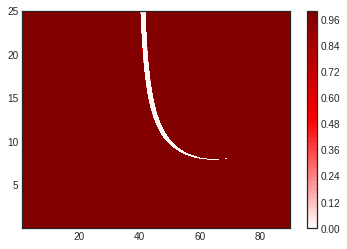

In [14]:
Z = vecCondition(findHeightAtTarget(X, Y)-Dt)
plt.contourf(X, Y, Z, 50, norm=MidpointNormalize(midpoint=0.), cmap='seismic')
plt.colorbar();

# Testing

## Speed of Function ##

In [28]:
def std(aList, bList):
  result = np.zeros(shape=(len(aList),len(bList)))
  for a in range(len(aList)):
    for b in range(len(bList)):
      result[a][b]=findHeightAtTarget(aList[a], bList[b])
  return result

In [50]:
array1=np.arange(1.0, 90.1, 0.1, dtype="float64")
array2=np.arange(0.001, 90.001, 0.001, dtype="float64")
A, B = np.meshgrid(angle, velocity)

In [51]:
%time findHeightAtTarget(A, B)

CPU times: user 149 ms, sys: 2.65 ms, total: 152 ms
Wall time: 155 ms


array([[-4.41583948e+05, -4.41612195e+05, -4.41643135e+05, ...,
        -3.62300179e+10, -1.44919632e+11, -1.98022905e+35],
       [-1.10395573e+05, -1.10402631e+05, -1.10410362e+05, ...,
        -9.05750382e+09, -3.62299066e+10, -4.95057261e+34],
       [-4.90643922e+04, -4.90675260e+04, -4.90709592e+04, ...,
        -4.02555678e+09, -1.61021798e+10, -2.20025450e+34],
       ...,
       [ 5.51658547e-01,  5.56896249e-01,  5.62134299e-01, ...,
         8.01955896e+02,  1.48746312e+03, -3.16887347e+26],
       [ 5.51658603e-01,  5.56896306e-01,  5.62134355e-01, ...,
         8.01960534e+02,  1.48748168e+03, -3.16861996e+26],
       [ 5.51658660e-01,  5.56896362e-01,  5.62134412e-01, ...,
         8.01965172e+02,  1.48750023e+03, -3.16836647e+26]])

In [31]:
%time std(array1, array2)

CPU times: user 21.5 s, sys: 53.8 ms, total: 21.5 s
Wall time: 21.6 s


array([[-2.40418228e+08, -6.01045564e+07, -2.67131358e+07, ...,
        -2.34726043e+00, -2.34660051e+00, -2.34594082e+00],
       [-2.40433609e+08, -6.01084018e+07, -2.67148449e+07, ...,
        -2.33522900e+00, -2.33456904e+00, -2.33390930e+00],
       [-2.40450457e+08, -6.01126138e+07, -2.67167169e+07, ...,
        -2.32321486e+00, -2.32255486e+00, -2.32189507e+00],
       ...,
       [-1.97252324e+13, -4.93130810e+12, -2.19169249e+12, ...,
        -2.41623812e+05, -2.41569669e+05, -2.41515544e+05],
       [-7.89006893e+13, -1.97251723e+13, -8.76674326e+12, ...,
        -9.70504454e+05, -9.70287883e+05, -9.70071384e+05],
       [-1.07812470e+38, -2.69531176e+37, -1.19791634e+37, ...,
        -1.33160991e+30, -1.33131398e+30, -1.33101815e+30]])

## Plotting

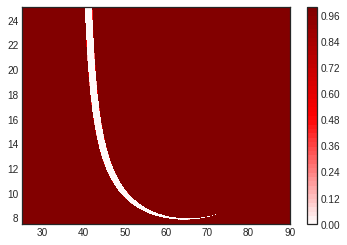

In [31]:
a=np.arange(25, 90.01, 0.1, dtype="float64")
b=np.arange(7.5, 25.1, 0.01, dtype="float64")
X, Y = np.meshgrid(a, b)
Z = vecCondition(findHeightAtTarget(X, Y)-Dt)
#Z = findHeightAtTarget(X, Y)-Dt
plt.contourf(X, Y, Z, 50, norm=MidpointNormalize(midpoint=0.), cmap='seismic')
plt.colorbar();
#print(X)
#print(Y)
#print(Z)

## Speed of Condiontal Formatting ##

In [9]:
def normalCondition(array):
  u = -0.5
  b = 0.5
  for i in range(len(array)):
    if array[i]<b and array[i]>u:
      array[i]=0
      
test = np.linspace(-1, 1, 2000001, dtype="float64")

In [53]:
%time normalCondition(test)

CPU times: user 951 ms, sys: 340 µs, total: 952 ms
Wall time: 953 ms


In [14]:
%time vecCondition(test)

CPU times: user 697 ms, sys: 297 ms, total: 993 ms
Wall time: 989 ms


array([1., 1., 1., ..., 1., 1., 1.])

In [17]:
!cat /proc/meminfo

MemTotal:       13305368 kB
MemFree:         3944916 kB
MemAvailable:    4499380 kB
Buffers:           51600 kB
Cached:           681212 kB
SwapCached:            0 kB
Active:          8482048 kB
Inactive:         532928 kB
Active(anon):    8249924 kB
Inactive(anon):    10660 kB
Active(file):     232124 kB
Inactive(file):   522268 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               324 kB
Writeback:             0 kB
AnonPages:       8282188 kB
Mapped:           341612 kB
Shmem:             11404 kB
KReclaimable:      83092 kB
Slab:             137088 kB
SReclaimable:      83092 kB
SUnreclaim:        53996 kB
KernelStack:        4912 kB
PageTables:        21696 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6652684 kB
Committed_AS:   11156120 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       51052 kB
VmallocChunk:          0 kB
Percpu:          